# Random Forest with PCA

When we plotted several 3d scatter plots after PCA transformation we have noticed that the data is splitted into several areas with respect to different principal component. As we know Decision Trees and Random forest make splits exactly along some axis. That gives us some sense to use RandomForest on the transformed data

In addition we will use SMOTE as we did it before

In [5]:
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
import copy

In [4]:
data = pd.read_csv("data.csv")
enc_data = pd.read_csv("encoded_data.csv")

X = enc_data.drop(columns = ['Churn', "customerID"])
y = enc_data['Churn'].values

## Splitting and PCA transformation

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

num_cols = ["tenure", 'MonthlyCharges', 'TotalCharges']

scaler= StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

pca = PCA(n_components = 10)

X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

oversample = SMOTE(sampling_strategy='minority')

X_train, y_train = oversample.fit_resample(X_train_reduced, y_train)
X_test, y_test = X_test_reduced, y_test

## RandomForest training

During the RandomForest training we will iterate over the count of proncipal component that we have taken. From 1 to 10. On each iteration we will train the model and evaluate it so we can observe changes in results of classification.

In [38]:
f1_train = []
f1_test = []

for n_components in tqdm(range(1, 11)):
    rf_model = RandomForestClassifier(n_estimators=120, n_jobs = -1, criterion="entropy",
                                      random_state=40, max_depth=13, min_samples_leaf=5)
    rf_model.fit(X_train[:, :n_components], y_train)
    predicted_test_y = rf_model.predict(X_test[:, :n_components])
    predicted_train_y = rf_model.predict(X_train[:, :n_components])

    f1_test.append(f1_score(y_test, predicted_test_y))
    f1_train.append(f1_score(y_train, predicted_train_y))

100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.19it/s]


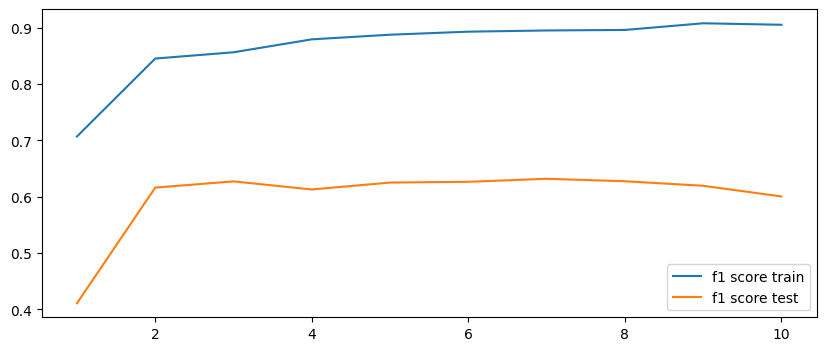

In [39]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot([i for i in range(1, 11)], f1_train, label="f1 score train")
ax.plot([i for i in range(1, 11)], f1_test, label="f1 score test")
ax.legend()

We see that the best f1-score we received for 3 principal components but generally after the second component the results' changing are not strong

In [41]:
model_rf = RandomForestClassifier(n_estimators=200, n_jobs = -1, max_depth=13,
                                  min_samples_leaf=10, criterion="entropy")

model_rf.fit(X_train[:, :5], y_train)
predicted_y = model_rf.predict(X_test[:, :5])
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

         0.0       0.89      0.79      0.84       777
         1.0       0.55      0.72      0.63       280

    accuracy                           0.77      1057
   macro avg       0.72      0.76      0.73      1057
weighted avg       0.80      0.77      0.78      1057

